In [44]:
import numpy as np
import time
from datetime import datetime
#get_ipython().run_line_magic('pip', 'install netCDF4')
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
class read_ibtracs_v4(object):
      """
        a function read /data2/clee/bttracks/IBTrACS.ALL.v04r00.nc
        the data is every 3 hours, and thus in order to get 6 hourly data, you need to add 'gap' variable
        netCDF4 library is required
        we use all USA agency - usa_lat, usa_lon, etc 
        atl - NHC ATL
        enp - NHC ENP
        wnp,sh,ni - JTWC for the rest: SH, IO, and WPC
        'global', it is reading all data
        

        lon is change to the range from 0 to 360

        to do task: use xarray to have better time calculations
        data = xr.to_nedcdf(filename)
      """
      def __init__(self,ncFileName,basins,gap):
        #ncFileName = 'IBTrACS.ALL.v04r00.nc'
        nc = netCDF4.Dataset(ncFileName,'r', format='NETCDF4_CLASSIC')
    ### filters global typhoon data based on input 'basins', which come from the list of basins defined by NCDC 
    ### (atlantic, western pacific, easter pacific, north indian, southern hemisphere, global)
        sourceN = []
        if 'atl' in basins:
           sourceN.extend(['NA'])
        if 'wnp' in basins:
           sourceN.extend(['WP'])
        if 'sh' in basins:
           sourceN.extend(['SA','SP','SI'])
        if 'ni' in basins:
           sourceN.extend(['NI'])
        if 'enp' in basins:
           sourceN.extend(['EP'])
        if 'global' in basins:
           sourceN = ['NA','WP','SA','SP','SI','NI','EP']
        sourceN = np.array(sourceN)
        print (sourceN,basins)
    ### collates filtered typhoons into an array
        arg=[]
        for i in range(sourceN.shape[0]):
            arg.extend(np.argwhere((nc.variables['basin'][:,0,0]==sourceN[i][0].encode("utf-8"))&
                        (nc.variables['basin'][:,0,1]==sourceN[i][1].encode("utf-8"))).ravel().tolist())
        arg = np.array(arg)
        print(arg)

    ### from nc dataset, import variables. data is in 3hr intervals, gap allows to filter less frequent 
    ### data (3n-hourly) [gap=2 is used]
        lon = nc.variables['usa_lon'][:][arg,::gap].T
        lat = nc.variables['usa_lat'][:][arg,::gap].T
        wspd = nc.variables['usa_wind'][:][arg,::gap].T
        days = nc.variables['time'][:][arg,::gap].T
        names = nc.variables['name'][:][arg,::gap].T
        stormID = nc.variables['numobs'][arg].T
        dist2land = nc.variables['dist2land'][:][arg,::gap].T
        trspeed = nc.variables['storm_speed'][:][arg,::gap].T
        trdir = nc.variables['storm_dir'][:][arg,::gap].T
        year = nc.variables['season'][arg].T
        times = nc.variables['iso_time'][:][arg,::gap,:].T

    ### define variables
        nNaN = np.argwhere(np.nanmax(np.array(lon),axis=0)!=-9999.).ravel()
        lon = lon[:,nNaN]
        lat = lat[:,nNaN]
        wspd = wspd[:,nNaN]
        days = days[:,nNaN]
        times = times[:,:,nNaN]
        names = names[:,nNaN]
        stormID = stormID[nNaN]
        dist2land = dist2land[:,nNaN]
        trspeed = trspeed[:,nNaN]
        trdir = trdir[:,nNaN]
        year = year[nNaN]

        a = np.nanmax(wspd,axis=0)
        arg = np.argwhere(a==a)[:,0]
        lon = np.array(lon[:,arg])
        lat = np.array(lat[:,arg])
        year = year[arg]
        wspd = np.float_(np.array(wspd[:,arg]))
        days = np.array(days[:,arg])
        dist2land = np.array(dist2land[:,arg])
        wspd[wspd==-9999.] = np.float('nan')
        lon[lon==-9999.] = np.float('nan')
        lat[lat==-9999.] = np.float('nan')
        stormID = np.array(stormID[arg])
        names = np.array(names[:,arg])
        trspeed = np.array(trspeed[:,arg])
        trdir = np.array(trdir[:,arg])
        times = np.array(times[:,:,arg])

        lon[lon<0]=lon[lon<0]+360
        self.wspd = wspd
        self.lon = lon
        self.lat = lat
        self.year = year
        self.days = days
        self.stormID = stormID
        self.names = names
        self.dist2land = dist2land
        self.year = year
        self.trspeed = trspeed
        self.trdir = trdir
        self.times = times
        self.r5 = np.zeros(year.shape)

In [5]:
bt = read_ibtracs_v4('/data2/clee/bttracks/IBTrACS.ALL.v04r00.nc','wnp',2)

['WP'] wnp
[  937   939   940 ... 13269 13270 13271]


/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in less


In [15]:
np.shape(bt.lon)

(180, 2077)

In [21]:
# Landfalling storms and times over the Philippines
# from Chia-Ying's script /home/jbaldwin/WorldBank/TCDATA/Main_Wind.py

liS = np.array([1516, 1521, 1522, 1523, 1525, 1537, 1543, 1544, 1546, 1548, 1550,
       1553, 1570, 1574, 1576, 1577, 1581, 1583, 1593, 1598, 1616, 1620,
       1621, 1624, 1634, 1636, 1637, 1639, 1643, 1647, 1649, 1669, 1670,
       1674, 1682, 1689, 1695, 1696, 1697, 1699, 1700, 1704, 1715, 1719,
       1720, 1721, 1722, 1744, 1746, 1747, 1750, 1751, 1753, 1756, 1769,
       1773, 1775, 1778, 1779, 1780, 1781, 1792, 1794, 1796, 1800, 1803,
       1808, 1809, 1820, 1829, 1831, 1836, 1840, 1846, 1848, 1849, 1853,
       1867, 1877, 1879, 1880, 1881, 1882, 1886, 1888, 1891, 1904, 1909,
       1910, 1911, 1912, 1916, 1918, 1923, 1929, 1930, 1935, 1936, 1937])

iLandfall = np.array([ 0,  5, 13,  1, 15, 22, 11, 11, 12,  8, 11, 18,  8,  6,  0,  3, 24,
       11,  6, 12, 12, 26, 11, 37, 10, 14,  9, 21, 17, 14, 38, 26, 20, 21,
        9,  5, 18, 37,  1, 16,  7, 14,  8, 20, 16, 25, 14, 12,  2, 25,  0,
        0, 13, 13, 11,  0,  0,  1, 20, 10,  5,  7,  5, 27, 21, 20, 14,  5,
       29,  9,  0,  8, 20, 17, 20, 11, 20, 15,  6, 32,  6,  7,  0,  6,  9,
       15, 14, 15, 13, 25,  2, 10,  6, 25, 17,  7,  5, 28,  5])

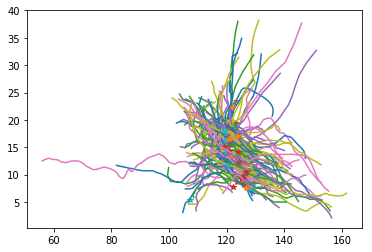

In [35]:
for num in range(np.shape(liS)[0]):
    n = liS[num]
    i = iLandfall[num]
    plt.plot(bt.lon[:,n],bt.lat[:,n])
    plt.plot(bt.lon[i,n],bt.lat[i,n],'*')

Text(0.5, 1.0, 'IBTrACS Typhoons Making Landfall in the Philippines')

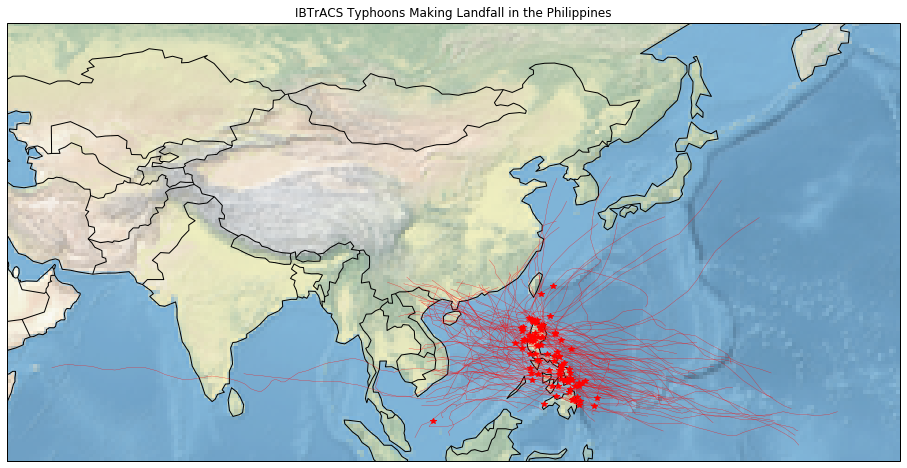

In [56]:
plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for num in range(np.shape(liS)[0]):
    n = liS[num]
    i = iLandfall[num]
    plt.plot(bt.lon[:,n],bt.lat[:,n],linewidth=0.25,color='r')
    plt.plot(bt.lon[i,n],bt.lat[i,n],'*',color='r')

ax.set_extent([50,170,0,40])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('IBTrACS Typhoons Making Landfall in the Philippines')